# Import Modules

In [1]:
import sys
import time
import pickle
from dataclasses import dataclass
import random as rnd
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from typing import Sequence, Any
import pandas as pd
import os
import json
import typing as tp

from datasets import load_dataset
import jax
from jax import (
    Array,
    numpy as jnp,
    random as jrand
)
import torch
import torchvision.transforms.v2.functional as tvF
try:
    from flash_attn_jax import flash_mha; del flash_mha
    USE_FLASH_ATT = True
except:
    USE_FLASH_ATT = False
import keras as nn; nn.utils.set_random_seed(42)
nn.mixed_precision.set_dtype_policy("mixed_float16") 
# https://github.com/keras-team/keras/pull/19621#event-12626049549 fixes use of float16 images with nn.ops.image.extract_patches

print("Python Version", sys.version); del sys
print(f"Keras Version: {nn.__version__} Backend: {nn.backend.backend()}")
print(f"Jax Version: {jax.__version__} Jax backend device: {jax.default_backend()}")
print(f"Torch Version: {torch.__version__}")

Python Version 3.11.8 (main, Feb 25 2024, 16:39:33) [GCC 11.4.0]
Keras Version: 3.0.4 Backend: jax
Jax Version: 0.4.23 Jax backend device: gpu
Torch Version: 2.3.0+cpu


# Dataset

In [2]:
def label_name_dict():
    from tiny_imagenet_ops import classes

    class_id = json.load(
        open("tiny_imagenet_ops/dataset_infos.json", "r")
    )["Maysee--tiny-imagenet"]["features"]["label"]["names"]

    label_id = {i:class_id[i] for i in range(len(class_id))}

    imagenet_id_clsstr = {}
    with open("tiny_imagenet_ops/map_clsloc.txt", mode="r") as f:
        lines = f.readlines()
        for line in lines:
            elements = line.split()
            if len(elements) >= 2:
                key = elements[0]
                value = elements[2]
                imagenet_id_clsstr[key] = value

    id_label = {}; not_in = []
    for key, value in label_id.items():
        try:
            id_label[key] = imagenet_id_clsstr[value]
        except:
            id_label[key] = classes.i2d[value]

    assert not_in == []
    return id_label

label_name = label_name_dict()

In [3]:
DATASET = 'zh-plus/tiny-imagenet'
# ~22s
train_dataset = pd.DataFrame(load_dataset(DATASET, split="train")).sample(frac=1, random_state=42).reset_index(drop=True)
val_dataset = pd.DataFrame(load_dataset(DATASET, split="valid")).sample(frac=1, random_state=42).reset_index(drop=True)

NUM_CLASSES = len(np.unique(train_dataset["label"].to_numpy()))

In [4]:
train_dataset

,image,label
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,151
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,160
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,39
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,153
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,185
...,...,...
99995,<PIL.JpegImagePlugin.JpegImageFile image mode=...,12
99996,<PIL.JpegImagePlugin.JpegImageFile image mode=...,109
99997,<PIL.JpegImagePlugin.JpegImageFile image mode=...,153
99998,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1


In [5]:
val_dataset

,image,label
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,125
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,93
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,34
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,94
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,90
...,...,...
9995,<PIL.JpegImagePlugin.JpegImageFile image mode=...,114
9996,<PIL.JpegImagePlugin.JpegImageFile image mode=...,103
9997,<PIL.JpegImagePlugin.JpegImageFile image mode=...,107
9998,<PIL.JpegImagePlugin.JpegImageFile image mode=...,17


In [6]:
def show_image(x, id:tp.Optional[int]=None, scale:bool=True):
    if not isinstance(x, (torch.Tensor, Array, np.ndarray)):
        x = np.array(x).astype(float)
        if scale:
            x /= 255.
    if id is not None:
        print(label_name[id])
    plt.imshow(x)
    plt.show()

In [7]:
def visualize_dataset(dataset:pd.DataFrame, num_images:int=25):
    images = dataset["image"][:num_images]
    labels = dataset["label"][:num_images]

    grid_size = int(len(images)**0.5)

    fig, axs = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(15, 8))

    for i, (img, img_cls) in enumerate(zip(images, labels)):
        row = i // grid_size
        col = i % grid_size

        # Plot the image in the corresponding subplot
        axs[row, col].imshow(img)
        axs[row, col].set_title(label_name[img_cls])
        axs[row, col].axis('off')  # Remove the axis ticks and labels

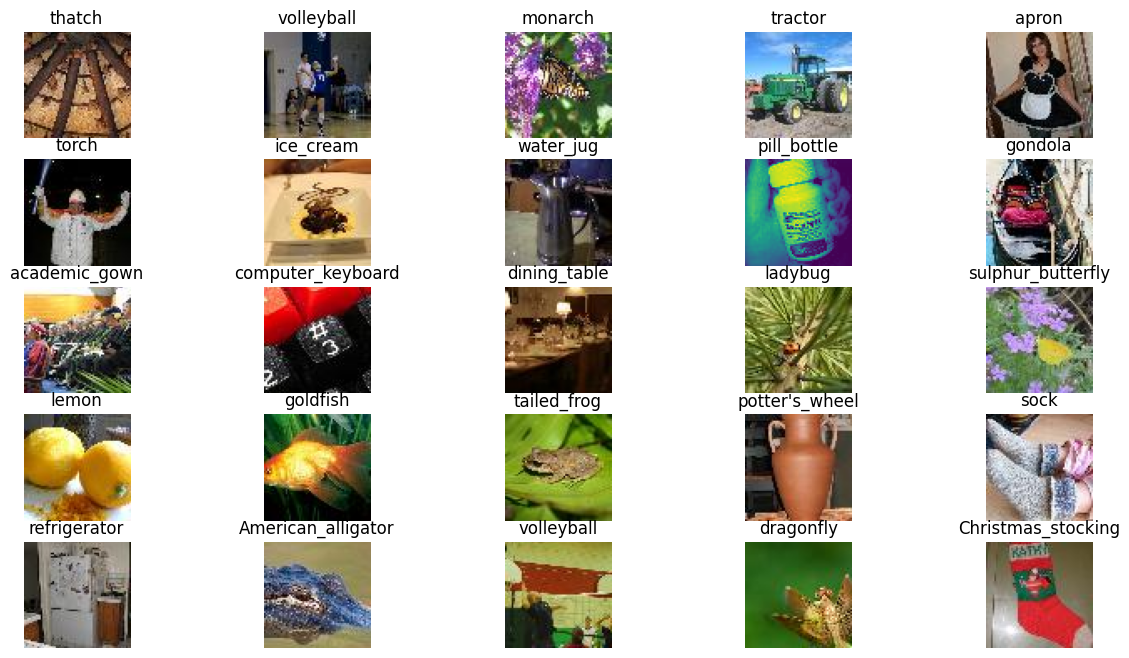

In [8]:
visualize_dataset(train_dataset)

In [9]:
train_dataset

,image,label
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,151
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,160
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,39
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,153
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,185
...,...,...
99995,<PIL.JpegImagePlugin.JpegImageFile image mode=...,12
99996,<PIL.JpegImagePlugin.JpegImageFile image mode=...,109
99997,<PIL.JpegImagePlugin.JpegImageFile image mode=...,153
99998,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1


bikini


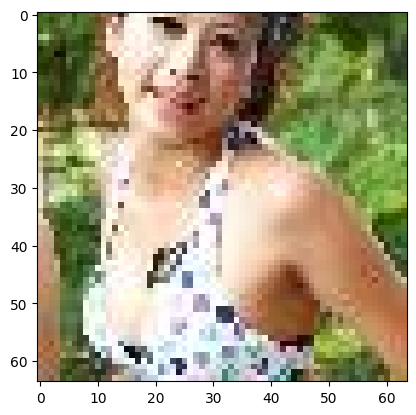

In [10]:
show_image(train_dataset["image"][80], train_dataset["label"][80])

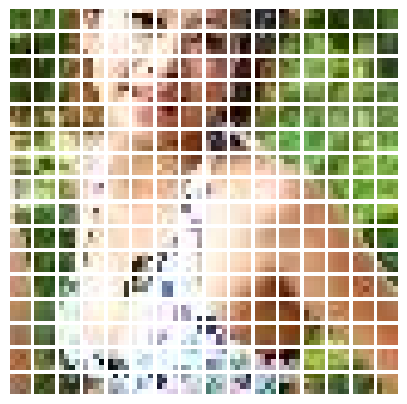

In [11]:
def visualize_patches(x:Array, patch_size:int):
    from vit import ops
    C = x.shape[-1]
    patches = ops.patchify(x.astype(float), patch_size)
    n = int(np.sqrt(patches.shape[1]))
    plt.figure(figsize=(5,5))
    for i, patch in enumerate(patches[0]):
        ax = plt.subplot(n, n, i + 1)
        patch_img = jnp.reshape(patch, (patch_size, patch_size, C))
        plt.imshow(patch_img, cmap="gray")
        plt.axis("off")

visualize_patches(jnp.array(train_dataset["image"][80])[None]/255., 4)

# Data Loader

In [12]:
class GetDataset(torch.utils.data.IterableDataset):
    def __init__(self, batch_size, dataset:pd.DataFrame):
        self.train_ds = dataset
        self.batch_size = batch_size

        self.ds_len = len(self.train_ds["image"])
        self.randint = lambda: rnd.randint(0, self.ds_len-1) # includes both ends, 0 and ds_len-1

    def __iter__(self):
        while True:
            for _ in range(self.batch_size):
                idx = self.randint()

                image = torch.from_numpy(np.asarray(self.train_ds["image"][idx])/255.)
                label = torch.tensor(self.train_ds["label"][idx])

                if image.shape[-1] != 3 and image.dim() != 3:
                    image = tvF.grayscale_to_rgb(
                        image[None] # (H, W) => (1, H, W)
                    ).moveaxis(0, -1) # (3, H, W) => (H, W, 3)
                yield image, label

# a = [np.asarray(train_dataset["image"][i]).shape for i in range(len(train_dataset["image"]))]
# a
# for i in range(len(train_dataset["image"])):
#     img = train_dataset["image"][i]
#     if  np.asarray(img).shape != (64, 64, 3):
#         show_image(img, train_dataset["label"][i])

In [13]:
class IterDataset:
    def __init__(self, batch_size:int):
        self.batch_size = batch_size

    def iter_batches(self, dataset:pd.DataFrame):
        ds = GetDataset(self.batch_size, dataset)
        dl = torch.utils.data.DataLoader(
            ds, batch_size=self.batch_size, pin_memory=True
        )

        for x, y in dl:
            yield x, y

# Config

In [14]:
@dataclass
class config:
    # ViT specifics
    patch_size:int = 4
    H:int = 64
    W:int = 64
    N:int = H*W//patch_size**2  # maxlen in transformer
    assert N*patch_size**2 == H*W

    # Transformer specifics
    d_model:int = 288
    num_heads:int = 6
    num_layers:int = 6
    num_classes:int = NUM_CLASSES
    dropout_rate:float = 0
    assert d_model % 2 == 0
    assert d_model % num_heads == 0

    use_flash_att:bool = USE_FLASH_ATT
    maxlen:int = N + 1
    
    # Tranining Args
    batch_size:int = 64
    num_steps:int = 7000
    eval_steps:int = 500
    checkpoint_dir:str = "weights/tiny_imagenet"
    eval_freq:int = 300
    num_grad_accumalation_steps:int = 1
    patience:int = 5

    ## Optimizers Args
    beta1:float = 0.9
    beta2:float = 0.999
    weight_decay:float = 0
    clipnorm:tp.Optional[float] = None

    ## learning rate schedule
    min_lr:float = 1e-7
    max_lr:float = 1e-3
    decay_steps:int = num_steps
    warmup_steps:int = 100


config()

config(patch_size=4, H=64, W=64, N=256, d_model=288, num_heads=6, num_layers=6, num_classes=200, dropout_rate=0, use_flash_att=True, maxlen=257, batch_size=64, num_steps=7000, eval_steps=500, checkpoint_dir='weights/tiny_imagenet', eval_freq=300, num_grad_accumalation_steps=1, patience=5, beta1=0.9, beta2=0.999, weight_decay=0, clipnorm=None, min_lr=1e-07, max_lr=0.001, decay_steps=7000, warmup_steps=100)

# Load Data Function

In [15]:
data_iterator = IterDataset(config.batch_size)
iter_ds = lambda split: data_iterator.iter_batches(
    dataset={"train": train_dataset, "val": val_dataset}[split]
)

# ViT Architechture

# Model

In [16]:
def build_model(model:nn.Model, input_shape:tuple|None=None, input_tensor:Array|None=None):
    assert not all([input_shape is None, input_tensor is None])
    if input_tensor is None:
        input_tensor = jrand.uniform(
            jrand.PRNGKey(32344), 
            shape=input_shape,
        )
    blabla = model(
        input_tensor,
        training=True
    ); del blabla
    return model

In [17]:
from vit.model import VIT

model = build_model(VIT(config), input_shape=(2, config.H, config.W, 3))
model.summary()

Model: "vit"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense (Dense)                   │ ?                         │     14,112 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_block               │ ?                         │    998,208 │
│ (TransformerBlock)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_block_1             │ ?                         │    998,208 │
│ (TransformerBlock)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_block_2             │ ?                         │    998,208 │
│ (TransformerBlock)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_block_3             │ ?                         │    998,208 │
│ (TransformerBlock)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_block_4             │ ?                         │    998,208 │
│ (TransformerBlock)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_block_5             │ ?                         │    998,208 │
│ (TransformerBlock)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ layer_normalization_12          │ ?                         │        576 │
│ (LayerNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_37 (Dense)                │ ?                         │     57,800 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 6,062,024 (23.12 MB)

 Trainable params: 6,062,024 (23.12 MB)

 Non-trainable params: 0 (0.00 B)

# Save weights ops

In [18]:
def save_object(dir_suffix_ftype:str, obj:Any):
    """
    dir_suffix_ftype: directory suffix and file type separated by "|"
    obj: Anything which is to be stored
    """
    dir, suffix, ftype = dir_suffix_ftype.split("|"); path = os.path.join(dir, "".join([suffix, f".{ftype}"]))
    os.makedirs(name=dir, exist_ok=True)
    with open(path, "wb") as file:
        pickle.dump(obj=obj, file=file, protocol=pickle.HIGHEST_PROTOCOL)
    return path

def load_object(path:str):
    with open(path, "rb") as file:
        obj = pickle.load(file)
    return obj

# Lr Schedule

In [19]:
learning_rate = nn.optimizers.schedules.CosineDecay(
    initial_learning_rate=config.min_lr,
    decay_steps=config.decay_steps,
    warmup_steps=config.warmup_steps,
    warmup_target=config.max_lr,
    alpha=config.min_lr/config.max_lr
)

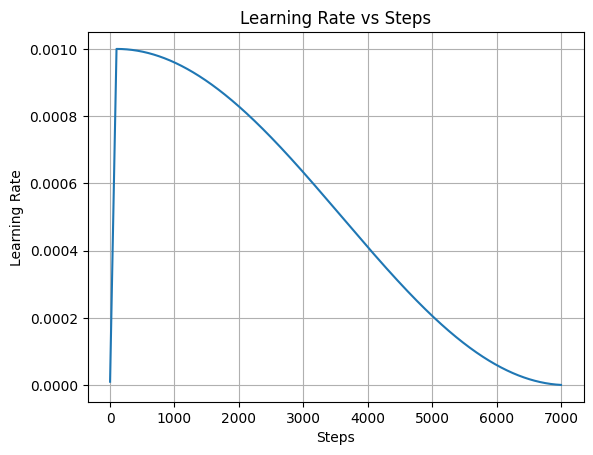

In [20]:
steps = jnp.arange(1, config.num_steps+1)
lrs = jax.vmap(learning_rate)(steps)

plt.plot(steps, lrs); del lrs, steps
plt.grid(True)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate vs Steps")
plt.show()

# Training

In [21]:
train_iterator, val_iterator = iter_ds(split="train"), iter_ds("val")

In [22]:
optimizer = nn.optimizers.LossScaleOptimizer(
    nn.optimizers.AdamW(
        learning_rate=learning_rate,
        beta_1=config.beta1,
        beta_2=config.beta2,
        clipnorm=config.clipnorm,
        weight_decay=config.weight_decay
    )
)
loss_fn = nn.losses.SparseCategoricalCrossentropy(from_logits=True)

@jax.jit
def get_accuracy(y_true:Array, logits:Array): # (B, T, num_classes), (B, T)
    batched_num_correct = (logits.argmax(-1)==y_true).sum(-1)/y_true.shape[-1] # (B,)
    accuracy = batched_num_correct.mean()
    return accuracy

@partial(jax.jit, static_argnums=-1)
def compute_loss(trainable_variables:list, non_trainable_variables:list, X_batch:Array, y_batch:Array, num_grad_accumalation_steps:int):
    logits, non_trainable_variables = model.stateless_call(
        trainable_variables,  non_trainable_variables,
        X_batch
    )
    loss = loss_fn(y_batch, logits)
    accuracy = get_accuracy(y_batch, logits)
    unscaled_loss = loss/num_grad_accumalation_steps
    scaled_loss = optimizer.scale_loss(unscaled_loss)
    return scaled_loss, (unscaled_loss, accuracy, non_trainable_variables)
grad_fn = jax.value_and_grad(compute_loss, has_aux=True)

@partial(jax.jit, static_argnums=-1)
def mini_step(train_state:Sequence[list], X_batch:Array, y_batch:Array, num_grad_accumalation_steps:int):
    trainable_variables, non_trainable_variables = train_state

    (_, aux), scaled_grad = grad_fn(
        trainable_variables, non_trainable_variables, X_batch, y_batch,
        num_grad_accumalation_steps
    )
    (unscaled_loss, accuracy, non_trainable_variables) = aux
    return scaled_grad, (unscaled_loss, accuracy), (trainable_variables, non_trainable_variables)

@jax.jit
def update_params(grads:list, trainable_variables:list, optimizer_variables:list):
    trainable_variables, optimizer_variables = optimizer.stateless_apply( # also handles scaled grads if LossScalerOPtimizer is used
        optimizer_variables, grads, trainable_variables
    ) # returns updated trainable_variables
    return trainable_variables, optimizer_variables

def evaluate(train_state:Sequence[list]):
    trainable_variables, non_trainable_variables = train_state
    mean_losses = []; mean_accuracies = []
    for eval_batch_iter in [train_iterator, val_iterator]:
        X_batch, y_batch = next(eval_batch_iter)
        losses = jnp.empty(config.eval_steps)
        accuracies = jnp.empty_like(losses)

        for eval_step in range(config.eval_steps):
            _, (unscaled_loss, accuracy, non_trainable_variables) = compute_loss(
                trainable_variables, non_trainable_variables,
                jnp.array(X_batch), jnp.array(y_batch), 1
            )
            losses = losses.at[eval_step].set(unscaled_loss)
            accuracies = accuracies.at[eval_step].set(accuracy)
            X_batch, y_batch = next(eval_batch_iter)
        mean_losses.append(losses.mean())
        mean_accuracies.append(accuracies.mean())
    return mean_losses, mean_accuracies # ([train_loss, val_loss], [train_accuracy, val_accuracy])

In [23]:
def train(return_best_states:bool):
    step = 1; wait = 0
    training_losses = {"train": []}

    trainable_variables = model.trainable_variables; optimizer.build(trainable_variables)
    non_trainable_variables = model.non_trainable_variables
    optimizer_variables = optimizer.variables

    best_step = 1
    best_train_state = (trainable_variables, non_trainable_variables)
    best_val_loss = 1e8

    t0 = time.time()
    print("Training about to start...")
    X_batch, y_batch = next(train_iterator)
    # TODO: Optimize Train Loop to reduce time per step
    while True:
        # condition to terminate
        if step > config.num_steps or wait > config.patience:
            print(f"Early Stopping at Step {step}." if wait > config.patience else "Training Terminated.")
            break
        
        # train model
        grads = jax.tree_util.tree_map(jnp.zeros_like, trainable_variables)
        for _ in range(config.num_grad_accumalation_steps):
            grad, (loss, accuracy), (trainable_variables, non_trainable_variables) = mini_step(
                (trainable_variables, non_trainable_variables), 
                jnp.array(X_batch), jnp.array(y_batch),
                config.num_grad_accumalation_steps
            )
            grads = jax.tree_util.tree_map(
                lambda g1, g2: jnp.add(g1, g2), grads, jax.tree_util.tree_map(jnp.asarray, grad)
            ) # sum grads for grad accumation
            X_batch, y_batch = next(train_iterator)
        grad = None # save memory

        loss = loss*config.num_grad_accumalation_steps # loss from last mini-step

        trainable_variables, optimizer_variables = update_params(
            grads, trainable_variables, optimizer_variables
        )
        grads = None # save memory

        if step % config.eval_freq == 0 or step == config.num_steps:
            print("Estimating Losses...")
            mean_losses, mean_accuracies = evaluate((trainable_variables, non_trainable_variables))
            print(
                f"\t| Training Loss: {mean_losses[0]:.4f} || Training Accuracy: {mean_accuracies[0]:.4f} |" 
                f"| Validation Loss: {mean_losses[1]:.4f} || Validation Accuracy: {mean_accuracies[1]:.4f} |"
            )
            
            _ = save_object(
                config.checkpoint_dir+f"|trstate{step}|weights",
                obj=best_train_state
            )
            print(f"Saved weights of step {step}.")

            if mean_losses[1] < best_val_loss:
                best_val_loss = mean_losses[1]
                best_train_state = (trainable_variables, non_trainable_variables)
                best_step = step
                wait = 0
            else:
                wait += 1

        # time
        t1 = time.time()
        dt = t1-t0; t0 = t1

        # print the essentials
        print(
            f"| Step: {step} || Loss: {loss:.4f} || Accuracy: {accuracy:.4f} |"
            f"| LR: {learning_rate(step):e} || dt: {dt*1000:.2f}ms |"
        )
        training_losses["train"].append(loss.tolist())
        step += 1
    
    if return_best_states:
        print(f"Best Weights are from Step {best_step}")
        print("With an Estimated Validation Loss of", best_val_loss)
        return best_train_state, training_losses

    return (trainable_variables, non_trainable_variables), training_losses

In [24]:
best_train_states, train_losses = train(return_best_states=True) # ~?mins

Training about to start...
| Step: 1 || Loss: 5.7454 || Accuracy: 0.0312 || LR: 1.009900e-05 || dt: 6939.02ms |
| Step: 2 || Loss: 5.8752 || Accuracy: 0.0000 || LR: 2.009800e-05 || dt: 196.92ms |
| Step: 3 || Loss: 5.9900 || Accuracy: 0.0000 || LR: 3.009700e-05 || dt: 62.81ms |
| Step: 4 || Loss: 5.9407 || Accuracy: 0.0000 || LR: 4.009600e-05 || dt: 62.61ms |
| Step: 5 || Loss: 5.7050 || Accuracy: 0.0000 || LR: 5.009500e-05 || dt: 63.29ms |
| Step: 6 || Loss: 5.9335 || Accuracy: 0.0000 || LR: 6.009400e-05 || dt: 60.93ms |
| Step: 7 || Loss: 5.5108 || Accuracy: 0.0312 || LR: 7.009300e-05 || dt: 60.68ms |
| Step: 8 || Loss: 5.6347 || Accuracy: 0.0000 || LR: 8.009200e-05 || dt: 60.79ms |
| Step: 9 || Loss: 5.4922 || Accuracy: 0.0000 || LR: 9.009100e-05 || dt: 62.13ms |
| Step: 10 || Loss: 5.5609 || Accuracy: 0.0000 || LR: 1.000900e-04 || dt: 62.59ms |
| Step: 11 || Loss: 5.6432 || Accuracy: 0.0000 || LR: 1.100890e-04 || dt: 61.46ms |
| Step: 12 || Loss: 5.6783 || Accuracy: 0.0000 || LR: 1

In [ ]:
_ = save_object(
    config.checkpoint_dir+f"|trstate|weights",
    obj=best_train_states
)

In [ ]:
plt.plot(train_losses["train"])
plt.title("Training Loss over Number of Steps")
plt.xlabel("Steps")
plt.ylabel("Train Loss")
plt.grid(True)
plt.show()

# Predictions

In [ ]:
def seePredictions(model:nn.Model, train_states:list, xs:list[Array], ys:list[Array]):
    trainable_variables, non_trainable_variables = train_states
    for x, y in zip(xs, ys): # (B, H, W, C)
        logits, non_trainable_variables = model.stateless_call(
            trainable_variables, non_trainable_variables, 
            x[None] # (1, H, W, C)
        ) # (1, num_classes)
        class_pred = logits.argmax(-1).squeeze()
        print("True Class:", y.tolist())
        print("Predicted Class:", class_pred.tolist())
        plt.imshow(x, cmap="gray")
        plt.show()

In [ ]:
# seePredictions(model, best_train_states, x_val[:50], y_val[:50])

```python
# Whats wrong in this?
def my_patchify(x, P): # (B, H, W, C)
    N = np.prod(x.shape[1:-1])//P**2
    assert N*P**2 == H*W, "<<-- should be True for patching"
    return x.reshape((-1, N, (P**2)*x.shape[-1]))
```